In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Utils

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from google.colab.patches import cv2_imshow

import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 랜덤 시드 설정
seed = 77
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



In [3]:
cd /content/drive/MyDrive

/content/drive/MyDrive


## Custom Dataset

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, root_dir, transform=None, infer=False):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'binary_masks')
        self.image_filenames = os.listdir(self.image_dir)

        self.infer = infer
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.tif')) #확장자 명만 다름

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #jpg랑 cv2에서 RGB 순서 다름.

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask/255

        #전처리입니다.
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Define Model

In [5]:
!pip install pretrained-backbones-unet

## Hyper Parameters

In [6]:
lr= 1e-4
epochs = 100
batch_size = 16


## Data Loader

In [7]:
train_transform = A.Compose(
    [
        A.RandomCrop(384, 384),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.3),
        A.Transpose(p=0.3),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomShadow(shadow_roi=(0, 0, 1, 1), p=0.1),

        A.OneOf([
            # A.ElasticTransform(p=1),
            A.OpticalDistortion(p=1),
            A.GridDistortion(p=1),
        ], p=0.1),
        A.Normalize(),
        ToTensorV2()
    ]
)
test_transform = A.Compose(
    [
        A.CenterCrop(384, 384),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = SatelliteDataset(root_dir='/content/drive/MyDrive/인지프/data/train', transform=train_transform) #train data 폴더 경로 넣기.
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12)

In [8]:
# dataset_size =  len(train_dataset)
# subset_size = int(0.1 * dataset_size )
# subset_indices = torch.randperm(dataset_size)[:subset_size]
# subset_dataset = Subset(train_dataset, subset_indices)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12)

In [9]:
test_dataset = SatelliteDataset(root_dir='/content/drive/MyDrive/인지프/data/test', transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=12)

# dataset_size =  len(test_dataset)
# # 10%의 Random dataset 데이터셋 생성
# subset_size = int(1.0 * dataset_size)
# subset_indices = torch.randperm(dataset_size)[:subset_size]
# mini_test = Subset(test_dataset, subset_indices)
# mini_test_loader = DataLoader(mini_test, batch_size, shuffle=True, num_workers=16)

## Model Train

In [10]:
# model 초기화
from backbones_unet.model.unet import Unet
model = Unet(
    backbone='tf_efficientnetv2_m_in21ft1k',
    in_channels=3,
    num_classes=1,
).to(device=device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

#### 10%로만 할지 말지 ####
# train_dataloader = subset_dataloader

train_losses = []
test_losses = []

# training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
      images = images.float().to(device)
      masks = masks.float().to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, masks.unsqueeze(1))

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
    train_losses.append(epoch_loss/len(train_dataloader))

    test_loss=0
    with torch.no_grad():
      model.eval()
      result = []
      for images, masks in tqdm(test_dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          test_loss += loss.item()
    test_losses.append(test_loss/len(test_dataloader))
    if epoch % 50 == 0:
      torch.save(model.state_dict(), f'./model{epoch}.pt')


    print(f'\nEpoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}, Test Loss : {test_loss/len(test_dataloader)}')



100%|██████████| 36/36 [00:06<00:00,  5.89it/s]



Epoch 1, Loss: 0.5654492220944829, Test Loss : 0.4258007945285903


100%|██████████| 36/36 [00:05<00:00,  6.06it/s]



Epoch 2, Loss: 0.3498506239718861, Test Loss : 0.3105909526348114


100%|██████████| 36/36 [00:06<00:00,  5.80it/s]



Epoch 3, Loss: 0.2925126010345088, Test Loss : 0.28204123799999553


100%|██████████| 36/36 [00:05<00:00,  6.01it/s]



Epoch 4, Loss: 0.26318559433437055, Test Loss : 0.2528396493030919


100%|██████████| 36/36 [00:06<00:00,  5.60it/s]



Epoch 5, Loss: 0.24391782449351418, Test Loss : 0.2525291521516111


100%|██████████| 36/36 [00:06<00:00,  5.98it/s]



Epoch 6, Loss: 0.22543110067231786, Test Loss : 0.22536087988151443


100%|██████████| 36/36 [00:06<00:00,  5.59it/s]



Epoch 7, Loss: 0.21508447184330887, Test Loss : 0.2146026370012098


100%|██████████| 36/36 [00:06<00:00,  5.99it/s]



Epoch 8, Loss: 0.20096205878588888, Test Loss : 0.2052858244213793


100%|██████████| 36/36 [00:06<00:00,  5.51it/s]



Epoch 9, Loss: 0.18778053402072853, Test Loss : 0.1977341624183787


100%|██████████| 36/36 [00:05<00:00,  6.06it/s]



Epoch 10, Loss: 0.17981769444627893, Test Loss : 0.1809766592664851


100%|██████████| 36/36 [00:06<00:00,  5.58it/s]



Epoch 11, Loss: 0.17098828539666203, Test Loss : 0.1756446340845691


100%|██████████| 36/36 [00:06<00:00,  5.96it/s]



Epoch 12, Loss: 0.16485416951278845, Test Loss : 0.16593898025651774


100%|██████████| 36/36 [00:06<00:00,  5.60it/s]



Epoch 13, Loss: 0.15780942142009735, Test Loss : 0.16282035782933235


100%|██████████| 36/36 [00:05<00:00,  6.02it/s]



Epoch 14, Loss: 0.1520590115752485, Test Loss : 0.15789679375787577


100%|██████████| 36/36 [00:06<00:00,  5.63it/s]



Epoch 15, Loss: 0.14330750165714157, Test Loss : 0.14908719942387608


100%|██████████| 36/36 [00:05<00:00,  6.00it/s]



Epoch 16, Loss: 0.139374032150954, Test Loss : 0.1413005225153433


100%|██████████| 36/36 [00:06<00:00,  5.57it/s]



Epoch 17, Loss: 0.1345396195538342, Test Loss : 0.14062677944699922


100%|██████████| 36/36 [00:06<00:00,  5.95it/s]



Epoch 18, Loss: 0.12808624830924803, Test Loss : 0.14148982055485249


100%|██████████| 36/36 [00:06<00:00,  5.62it/s]



Epoch 19, Loss: 0.12668970429028073, Test Loss : 0.13907420190258157


100%|██████████| 36/36 [00:06<00:00,  6.00it/s]



Epoch 20, Loss: 0.12193061664907469, Test Loss : 0.13539446817917955


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]



Epoch 21, Loss: 0.12074142813475595, Test Loss : 0.14065304595149225


100%|██████████| 36/36 [00:06<00:00,  5.96it/s]



Epoch 22, Loss: 0.11726464750245214, Test Loss : 0.12579319315652052


100%|██████████| 36/36 [00:06<00:00,  5.66it/s]



Epoch 23, Loss: 0.11506073332081239, Test Loss : 0.12867054156959057


100%|██████████| 36/36 [00:06<00:00,  5.97it/s]



Epoch 24, Loss: 0.11289371824305919, Test Loss : 0.12235525084866418


100%|██████████| 36/36 [00:06<00:00,  5.55it/s]



Epoch 25, Loss: 0.10836008646421963, Test Loss : 0.11976455162382788


100%|██████████| 36/36 [00:06<00:00,  5.96it/s]



Epoch 26, Loss: 0.1068234568875697, Test Loss : 0.11949643694485228


100%|██████████| 36/36 [00:06<00:00,  5.62it/s]



Epoch 27, Loss: 0.10735984829564889, Test Loss : 0.1178510055049426


100%|██████████| 36/36 [00:05<00:00,  6.07it/s]



Epoch 28, Loss: 0.10312087135389447, Test Loss : 0.11943168187927869


100%|██████████| 36/36 [00:06<00:00,  5.61it/s]



Epoch 29, Loss: 0.10563966016181642, Test Loss : 0.11708660915287004


100%|██████████| 36/36 [00:05<00:00,  6.01it/s]



Epoch 30, Loss: 0.10370784281339082, Test Loss : 0.11407797183427545


100%|██████████| 36/36 [00:06<00:00,  5.65it/s]



Epoch 31, Loss: 0.09857173941822515, Test Loss : 0.1165842838688857


100%|██████████| 36/36 [00:05<00:00,  6.01it/s]



Epoch 32, Loss: 0.09909522155713704, Test Loss : 0.11196371219638321


100%|██████████| 36/36 [00:06<00:00,  5.56it/s]



Epoch 33, Loss: 0.09784921649326053, Test Loss : 0.10841479405967726


100%|██████████| 36/36 [00:06<00:00,  5.96it/s]



Epoch 34, Loss: 0.09471497069009477, Test Loss : 0.11088687750614351


100%|██████████| 36/36 [00:06<00:00,  5.57it/s]



Epoch 35, Loss: 0.09264126531262365, Test Loss : 0.11131329865505298


100%|██████████| 36/36 [00:05<00:00,  6.03it/s]



Epoch 36, Loss: 0.09385646302770409, Test Loss : 0.10939737605965799


100%|██████████| 36/36 [00:06<00:00,  5.63it/s]



Epoch 37, Loss: 0.0943676957136227, Test Loss : 0.11510303717417021


100%|██████████| 36/36 [00:05<00:00,  6.04it/s]



Epoch 38, Loss: 0.09292286228285068, Test Loss : 0.11300771202271183


100%|██████████| 36/36 [00:06<00:00,  5.54it/s]



Epoch 39, Loss: 0.09435566553535561, Test Loss : 0.10858557021452321


100%|██████████| 36/36 [00:05<00:00,  6.03it/s]



Epoch 40, Loss: 0.0929428465767867, Test Loss : 0.11024223218878938


100%|██████████| 36/36 [00:06<00:00,  5.66it/s]



Epoch 41, Loss: 0.08895794884301722, Test Loss : 0.10937156590322654


100%|██████████| 36/36 [00:06<00:00,  5.89it/s]



Epoch 42, Loss: 0.08915653687694834, Test Loss : 0.10921104495517081


100%|██████████| 36/36 [00:06<00:00,  5.58it/s]



Epoch 43, Loss: 0.09091845633358592, Test Loss : 0.10614418861870137


100%|██████████| 36/36 [00:06<00:00,  6.00it/s]



Epoch 44, Loss: 0.08573088846686813, Test Loss : 0.10528681975685888


100%|██████████| 36/36 [00:06<00:00,  5.66it/s]



Epoch 45, Loss: 0.08594323423070212, Test Loss : 0.11491877973700564


100%|██████████| 36/36 [00:06<00:00,  5.98it/s]



Epoch 46, Loss: 0.08618202683929768, Test Loss : 0.1151618476336201


100%|██████████| 36/36 [00:06<00:00,  5.71it/s]



Epoch 47, Loss: 0.08860630909394887, Test Loss : 0.1133809327147901


100%|██████████| 36/36 [00:05<00:00,  6.07it/s]



Epoch 48, Loss: 0.08537522382620308, Test Loss : 0.10841676957594852


100%|██████████| 36/36 [00:06<00:00,  5.59it/s]



Epoch 49, Loss: 0.09058114612061116, Test Loss : 0.11410052709591885


100%|██████████| 36/36 [00:06<00:00,  5.96it/s]



Epoch 50, Loss: 0.0849648388620052, Test Loss : 0.11293112023526596


100%|██████████| 36/36 [00:06<00:00,  5.65it/s]



Epoch 51, Loss: 0.08535578011328147, Test Loss : 0.10710317706171837


100%|██████████| 36/36 [00:06<00:00,  5.90it/s]



Epoch 52, Loss: 0.08159891655668616, Test Loss : 0.10819191089831293


100%|██████████| 36/36 [00:06<00:00,  5.97it/s]



Epoch 53, Loss: 0.08294853614643216, Test Loss : 0.1064219080015189


100%|██████████| 36/36 [00:06<00:00,  5.62it/s]



Epoch 54, Loss: 0.08407870447263122, Test Loss : 0.11255685954044263


100%|██████████| 36/36 [00:06<00:00,  5.94it/s]



Epoch 55, Loss: 0.08316564073579179, Test Loss : 0.10710932839558357


100%|██████████| 36/36 [00:06<00:00,  5.61it/s]



Epoch 56, Loss: 0.08286782664557298, Test Loss : 0.1148208529015796


100%|██████████| 36/36 [00:05<00:00,  6.00it/s]



Epoch 57, Loss: 0.08087433778887822, Test Loss : 0.1079086161011623


100%|██████████| 36/36 [00:06<00:00,  5.63it/s]



Epoch 58, Loss: 0.08034316740102238, Test Loss : 0.11140142352734175


100%|██████████| 36/36 [00:05<00:00,  6.07it/s]



Epoch 59, Loss: 0.07931172420891623, Test Loss : 0.10442730080750254


100%|██████████| 36/36 [00:06<00:00,  5.60it/s]



Epoch 60, Loss: 0.07930779360079517, Test Loss : 0.10768436438714464


100%|██████████| 36/36 [00:06<00:00,  5.98it/s]



Epoch 61, Loss: 0.0778133284766227, Test Loss : 0.10580240371119645


100%|██████████| 36/36 [00:06<00:00,  5.61it/s]



Epoch 62, Loss: 0.08056962689281338, Test Loss : 0.10482565137661165


100%|██████████| 36/36 [00:06<00:00,  6.00it/s]



Epoch 63, Loss: 0.07899340679351655, Test Loss : 0.10480603389441967


100%|██████████| 36/36 [00:06<00:00,  5.62it/s]



Epoch 64, Loss: 0.08341971200166477, Test Loss : 0.1081370054744184


100%|██████████| 36/36 [00:06<00:00,  5.96it/s]



Epoch 65, Loss: 0.0810661277630263, Test Loss : 0.1040894562482006


100%|██████████| 36/36 [00:06<00:00,  5.69it/s]



Epoch 66, Loss: 0.07818303883282675, Test Loss : 0.10438347902769844


100%|██████████| 36/36 [00:05<00:00,  6.07it/s]



Epoch 67, Loss: 0.07705063903186884, Test Loss : 0.10522480950587326


100%|██████████| 36/36 [00:06<00:00,  5.87it/s]



Epoch 68, Loss: 0.07802834930933183, Test Loss : 0.10057332615057628


100%|██████████| 36/36 [00:06<00:00,  5.93it/s]



Epoch 69, Loss: 0.07673773425631225, Test Loss : 0.10619631436808656


100%|██████████| 36/36 [00:06<00:00,  5.97it/s]



Epoch 70, Loss: 0.07858338012980919, Test Loss : 0.10736632235865626


100%|██████████| 36/36 [00:06<00:00,  5.76it/s]



Epoch 71, Loss: 0.07782912970934477, Test Loss : 0.10206311886819701


100%|██████████| 36/36 [00:05<00:00,  6.04it/s]



Epoch 72, Loss: 0.07720496518433922, Test Loss : 0.10620437927233677


100%|██████████| 36/36 [00:06<00:00,  5.65it/s]



Epoch 73, Loss: 0.07879855514814456, Test Loss : 0.10477503559862573


100%|██████████| 36/36 [00:06<00:00,  5.92it/s]



Epoch 74, Loss: 0.07553500291477475, Test Loss : 0.10002691575532986


100%|██████████| 36/36 [00:06<00:00,  5.63it/s]



Epoch 75, Loss: 0.07713081020240982, Test Loss : 0.10148514504544437


100%|██████████| 36/36 [00:06<00:00,  6.00it/s]



Epoch 76, Loss: 0.07564089757700761, Test Loss : 0.10042814504251713


100%|██████████| 36/36 [00:06<00:00,  5.61it/s]



Epoch 77, Loss: 0.07551860923154487, Test Loss : 0.10030139488581982


100%|██████████| 36/36 [00:06<00:00,  5.97it/s]



Epoch 78, Loss: 0.07514909841120243, Test Loss : 0.09812291230385502


100%|██████████| 36/36 [00:06<00:00,  5.70it/s]



Epoch 79, Loss: 0.07213571991047098, Test Loss : 0.10425648737388353


100%|██████████| 36/36 [00:05<00:00,  6.03it/s]



Epoch 80, Loss: 0.07515384453452295, Test Loss : 0.0995968889652027


100%|██████████| 36/36 [00:06<00:00,  5.84it/s]



Epoch 81, Loss: 0.07218477292917669, Test Loss : 0.0972913141336499


100%|██████████| 36/36 [00:06<00:00,  5.79it/s]



Epoch 82, Loss: 0.07246668191833629, Test Loss : 0.09890040255979532


100%|██████████| 36/36 [00:05<00:00,  6.00it/s]



Epoch 83, Loss: 0.07731855061784801, Test Loss : 0.09964659644497766


100%|██████████| 36/36 [00:06<00:00,  5.53it/s]



Epoch 84, Loss: 0.07390094279415077, Test Loss : 0.10008035411333872


100%|██████████| 36/36 [00:05<00:00,  6.02it/s]



Epoch 85, Loss: 0.07351794890645477, Test Loss : 0.11357053648680449


100%|██████████| 36/36 [00:06<00:00,  5.62it/s]



Epoch 86, Loss: 0.07340919554957913, Test Loss : 0.10356277982807821


100%|██████████| 36/36 [00:06<00:00,  5.95it/s]



Epoch 87, Loss: 0.07180919958692458, Test Loss : 0.10225716830852132


100%|██████████| 36/36 [00:06<00:00,  5.64it/s]



Epoch 88, Loss: 0.0718151839941533, Test Loss : 0.09777943696826696


100%|██████████| 36/36 [00:05<00:00,  6.01it/s]



Epoch 89, Loss: 0.07273295550193223, Test Loss : 0.10232394528833942


100%|██████████| 36/36 [00:06<00:00,  5.63it/s]



Epoch 90, Loss: 0.07059305764010383, Test Loss : 0.09810702037066221


100%|██████████| 36/36 [00:06<00:00,  5.96it/s]



Epoch 91, Loss: 0.07091953507107165, Test Loss : 0.10045951206444038


100%|██████████| 36/36 [00:06<00:00,  5.67it/s]



Epoch 92, Loss: 0.0720006651374408, Test Loss : 0.10210604325402528


100%|██████████| 36/36 [00:05<00:00,  6.04it/s]



Epoch 93, Loss: 0.07017419044859707, Test Loss : 0.09943538174654047


100%|██████████| 36/36 [00:06<00:00,  5.87it/s]



Epoch 94, Loss: 0.07051890115771028, Test Loss : 0.09807527417110072


100%|██████████| 36/36 [00:06<00:00,  5.85it/s]



Epoch 95, Loss: 0.0700242369202897, Test Loss : 0.09792484226636589


100%|██████████| 36/36 [00:06<00:00,  5.99it/s]



Epoch 96, Loss: 0.06941833379419728, Test Loss : 0.0996888279914856


100%|██████████| 36/36 [00:06<00:00,  5.65it/s]



Epoch 97, Loss: 0.0708820782860534, Test Loss : 0.09753798791724774


100%|██████████| 36/36 [00:06<00:00,  5.97it/s]



Epoch 98, Loss: 0.07157008957842158, Test Loss : 0.10157413662980413


100%|██████████| 36/36 [00:06<00:00,  5.61it/s]



Epoch 99, Loss: 0.06917739421543148, Test Loss : 0.10017715161666274


100%|██████████| 36/36 [00:06<00:00,  5.95it/s]


Epoch 100, Loss: 0.06987046026107338, Test Loss : 0.10056116813535078


In [11]:
torch.save(model.state_dict(), './eff_m.pt')

## Epoch에 따른 Loss 변화

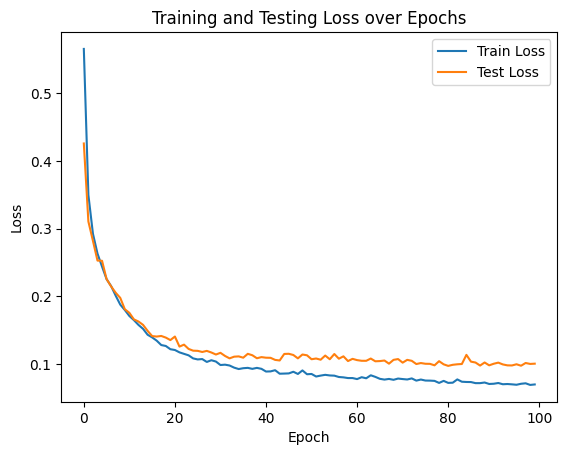

In [12]:

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 잘 되는지 결과 이미지 출력해보기

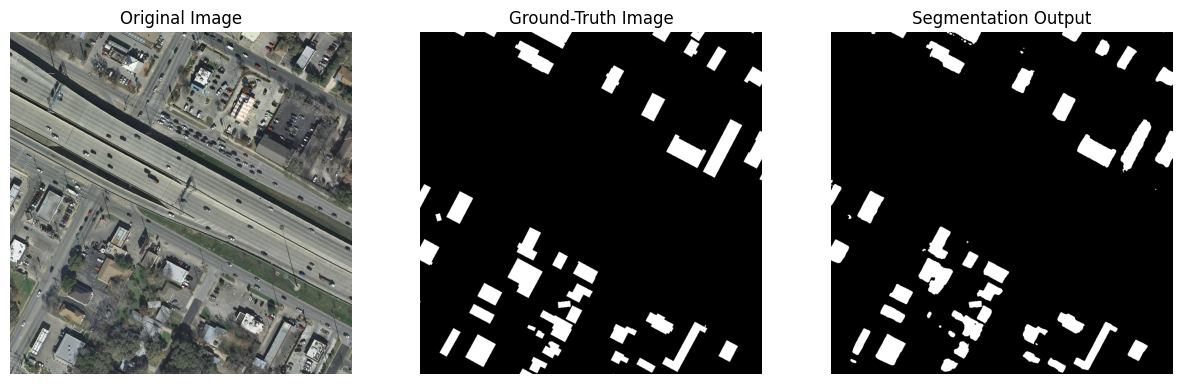

In [13]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 모델 인스턴스 생성 및 가중치 로드
model_trained = model # Unet
# model_trained = Unet_resnet.to(device) # Unet + Resnet
# model_trained.load_state_dict(torch.load('./model.pt')) # 가중치파일 경로
model_trained.eval() # 평가 모드로 설정

# 이미지 전처리
def preprocess_image(image_path):
    input_image = Image.open(image_path)
    preprocess = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ])
    input_tensor = preprocess(image=np.array(input_image))['image']
    input_batch = input_tensor.unsqueeze(0) # 배치 차원 추가
    return input_batch

# 이미지 경로
image_path = '/content/drive/MyDrive/인지프/inria/cropped_1024/austin1/images/austin1_0_0.jpg'
gt_path = '/content/drive/MyDrive/인지프/inria/cropped_1024/austin1/binary_masks/austin1_0_0.tif'

# 이미지 전처리 및 예측 수행
with torch.no_grad():
    input_batch = preprocess_image(image_path)
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model_trained.to('cuda')

    output = model_trained(input_batch)

# 결과 처리
output = torch.sigmoid(output).squeeze(0).permute(1,2,0).cpu().numpy() # Sigmoid 적용 및 이미지 형태로 변환
output = (output > 0.5).astype(np.uint8) # Threshold 적용

# 원본 이미지 보기
plt.figure(figsize=(15, 5))  # 전체 그림의 크기를 늘림

original_image = Image.open(image_path)
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original Image")

# ground truth 이미지 보기
gt_image = Image.open(gt_path)
plt.subplot(1, 3, 2)
plt.imshow(gt_image)
plt.axis('off')
plt.title("Ground-Truth Image")

# 결과 이미지 보기 (Matplotlib 사용)
plt.subplot(1, 3, 3)
plt.imshow(output, cmap='gray')  # 'gray'는 흑백 이미지인 경우 사용
plt.axis('off')  # 축 제거
plt.title("Segmentation Output")

plt.show()


In [14]:
# model = Unet_resnet.to(device) # Unet + Resnet
# model.load_state_dict(torch.load('./model50.pt')) # 가중치파일 경로
model.eval() # 평가 모드로 설정

all_true_masks = []
all_predicted_masks = []
with torch.no_grad():
    model.eval()
    result = []
    for images, masks in tqdm(test_dataloader):
        images = images.float().to(device)
        true_masks = masks.float().to(device)

        outputs = model(images)

        # CPU로 이동
        true_masks = true_masks.squeeze().cpu().numpy()
        outputs = outputs.squeeze().cpu().numpy()
        outputs = (outputs > 0.5).astype(np.uint8)


        # 리스트에 추가
        all_true_masks.extend(true_masks)
        all_predicted_masks.extend(outputs)

# 실제 마스크와 예측 마스크 비교
true_masks_flat = np.concatenate(all_true_masks).ravel()
predicted_masks_flat = np.concatenate(all_predicted_masks).ravel()

# Precision, Recall, IoU, Dice 계산
# precision = precision_score(true_masks_flat, predicted_masks_flat)
# recall = recall_score(true_masks_flat, predicted_masks_flat)
iou = jaccard_score(true_masks_flat, predicted_masks_flat)
dice_coefficient = f1_score(true_masks_flat, predicted_masks_flat)

# 결과 출력
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
print(f'IoU: {iou}')
print(f'Dice Coefficient: {dice_coefficient}')



100%|██████████| 36/36 [00:07<00:00,  4.85it/s]


IoU: 0.7877869971732757
Dice Coefficient: 0.8812984974371887
